# BIBLIOTECAS

In [34]:
import warnings

import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
import category_encoders     as ce

from scipy                   import stats

from IPython.display         import display, HTML
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.pipeline        import Pipeline
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import StandardScaler
from sklearn.preprocessing   import RobustScaler

from sklearn.impute          import KNNImputer
from sklearn.impute          import SimpleImputer

from sklearn.metrics         import mean_absolute_error
from sklearn.metrics         import mean_absolute_percentage_error
from sklearn.metrics         import mean_squared_error

from sklearn.neighbors       import LocalOutlierFactor
from sklearn.ensemble        import IsolationForest
from sklearn.cluster         import DBSCAN
from xgboost                 import XGBRegressor

## FUNÇÕES AUXILIARES

In [35]:
# expandindo a área do notebook
display(HTML("<style>.container { width:75% !important; }</style>"))

# ignorar warnings
warnings.simplefilter("ignore")

## CARREGANDO O DATASET

In [36]:
cars_data = pd.read_csv('data/autoscout24-germany-dataset.csv')

# VISÃO GERAL DOS DADOS

In [3]:
cars_data.head()

,mileage,make,model,fuel,gear,offerType,price,hp,year
0,235000,BMW,316,Diesel,Manual,Used,6800,116.0,2011
1,92800,Volkswagen,Golf,Gasoline,Manual,Used,6877,122.0,2011
2,149300,SEAT,Exeo,Gasoline,Manual,Used,6900,160.0,2011
3,96200,Renault,Megane,Gasoline,Manual,Used,6950,110.0,2011
4,156000,Peugeot,308,Gasoline,Manual,Used,6950,156.0,2011


## DIMENSÃO DOS DADOS

In [4]:
print('Número de linhas: {}'.format(cars_data.shape[0]))
print('Número de colunas: {}'.format(cars_data.shape[1]))

Número de linhas: 46405
Número de colunas: 9


## VERIFICANDO DADOS DUPLICADOS

In [5]:
# quantidade de dados duplicados
pd.DataFrame.duplicated(cars_data).sum()

2140

In [6]:
# quantidade de dados duplicados em porcentagem
(pd.DataFrame.duplicated(cars_data).sum() / len(cars_data))*100

4.611572028876198

### REMOVENDO DADOS DUPLICADOS

In [7]:
cars_data = cars_data.drop_duplicates(keep='first')

In [8]:
# dimensão do dataset após remover
cars_data.shape

(44265, 9)

## CHECANDO DADOS FALTANTES

In [9]:
# verificando dados NA por variável
cars_data.isna().sum()

mileage        0
make           0
model        137
fuel           0
gear         175
offerType      0
price          0
hp            24
year           0
dtype: int64

In [10]:
# verificando a porcentagem de dados NA por variável
(cars_data.isna().sum().sort_values(ascending=False)/len(cars_data))*100

gear         0.395346
model        0.309500
hp           0.054219
mileage      0.000000
make         0.000000
fuel         0.000000
offerType    0.000000
price        0.000000
year         0.000000
dtype: float64

In [11]:
# verificando a porcentagem de dados NA em todo o dataset
missing_values = cars_data.isnull().sum()

total_cells = np.product(cars_data.shape)
total_missing = missing_values.sum()

percent_na = (total_missing/total_cells) * 100
percent_na

0.08434052486915923

## RESUMO DOS DADOS

In [12]:
cars_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44265 entries, 0 to 46399
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   mileage    44265 non-null  int64  
 1   make       44265 non-null  object 
 2   model      44128 non-null  object 
 3   fuel       44265 non-null  object 
 4   gear       44090 non-null  object 
 5   offerType  44265 non-null  object 
 6   price      44265 non-null  int64  
 7   hp         44241 non-null  float64
 8   year       44265 non-null  int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 3.4+ MB


In [13]:
# quantidade de variáveis únicas por feature
cars_data.nunique().sort_values(ascending=False)

mileage      20117
price         6668
model          841
hp             328
make            77
fuel            11
year            11
offerType        5
gear             3
dtype: int64

## VERIFICANDO AS MEDIDAS ESTATÍSTICAS

In [14]:
cars_data.describe().round()

,mileage,price,hp,year
count,44265.0,44265.0,44241.0,44265.0
mean,72257.0,16554.0,134.0,2016.0
std,62361.0,19458.0,75.0,3.0
min,0.0,1100.0,1.0,2011.0
25%,21429.0,7490.0,86.0,2013.0
50%,61111.0,10990.0,116.0,2016.0
75%,106000.0,19490.0,150.0,2019.0
max,1111111.0,1199900.0,850.0,2021.0


# EDA

## VERIFICANDO AS VARIÁVEIS NUMÉRICAS

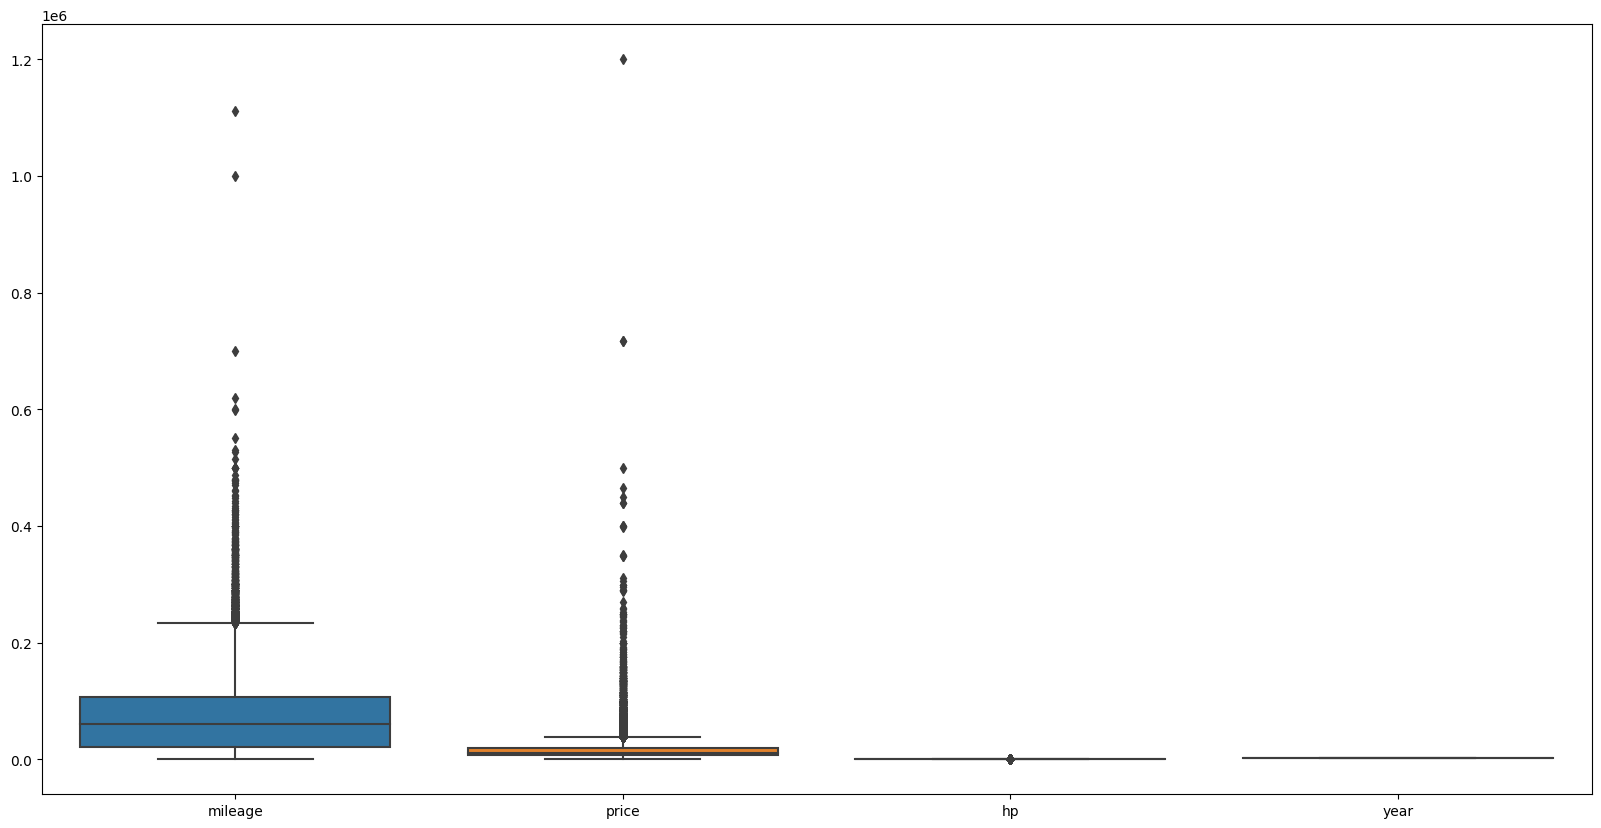

In [16]:
plt.figure(figsize=(20,10))
sns.boxplot(cars_data);

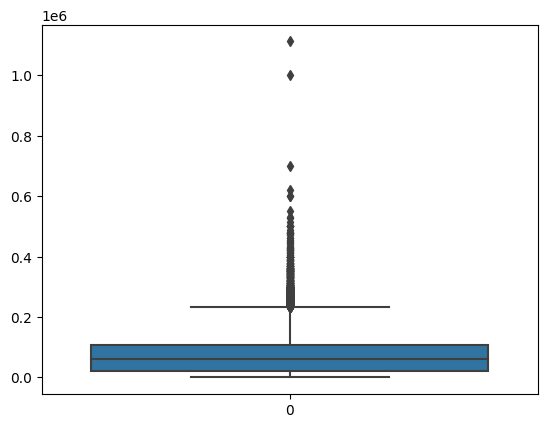

In [17]:
sns.boxplot(cars_data['mileage']);

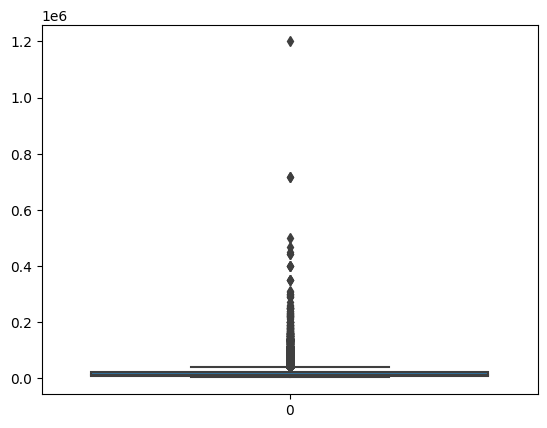

In [18]:
sns.boxplot(cars_data['price']);

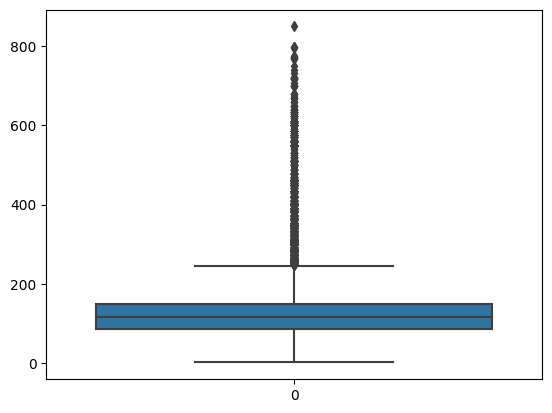

In [19]:
sns.boxplot(cars_data['hp']);

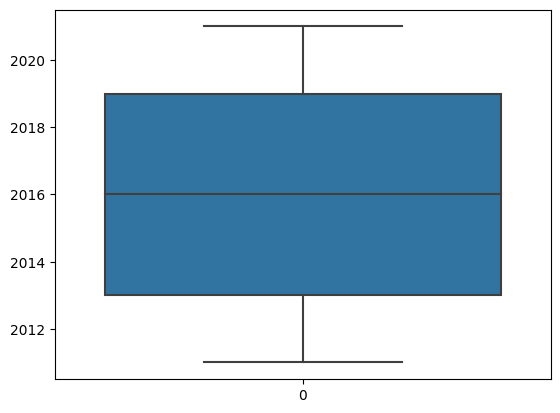

In [20]:
sns.boxplot(cars_data['year']);

### DISTRIBUIÇÃO DE VEÍCULOS POR QUILOMETRAGEM

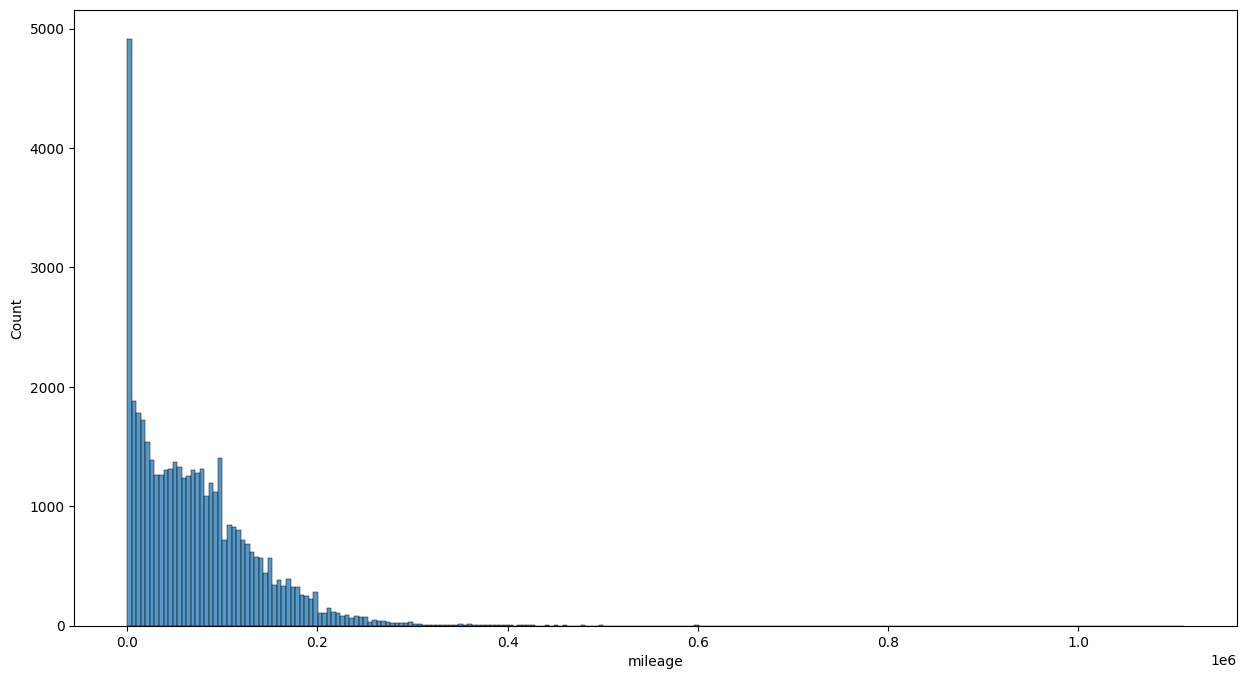

In [21]:
plt.figure(figsize=(15,8))
sns.histplot(cars_data['mileage']);

### DISTRIBUIÇÃO DE VEÍCULOS POR PREÇO

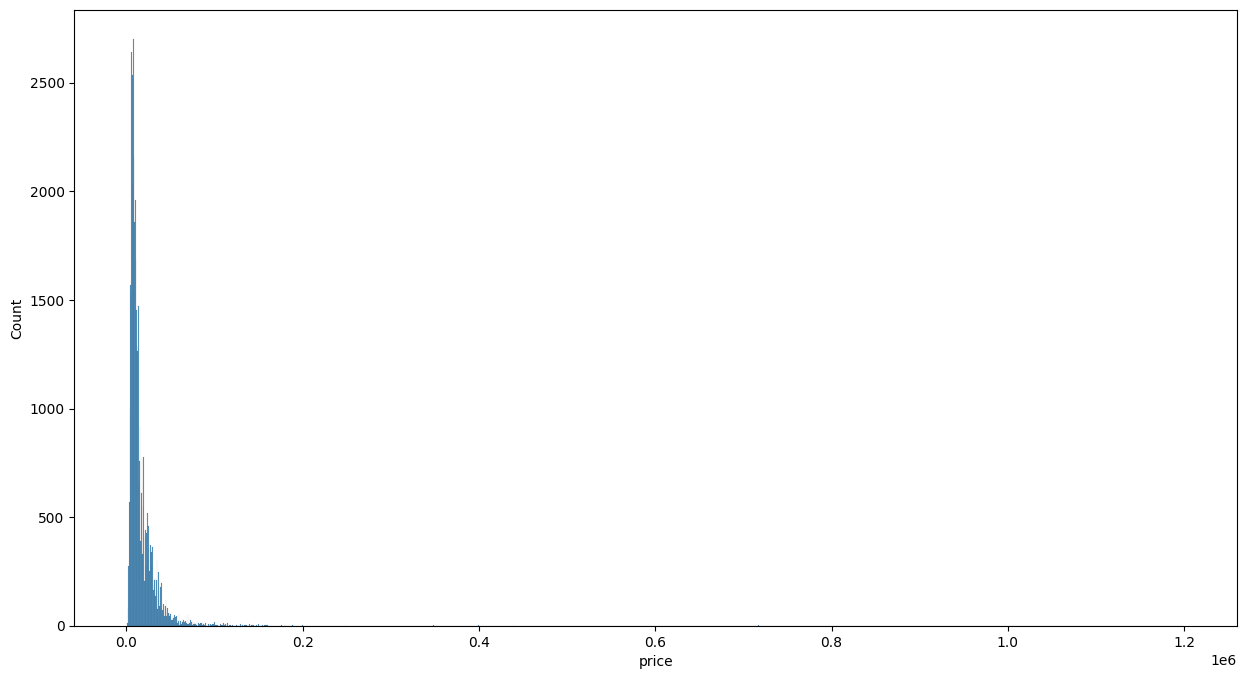

In [22]:
plt.figure(figsize=(15,8))
sns.histplot(cars_data['price']);

### DISTRIBUIÇÃO DE VEÍCULOS POR POTÊNCIA DO MOTOR

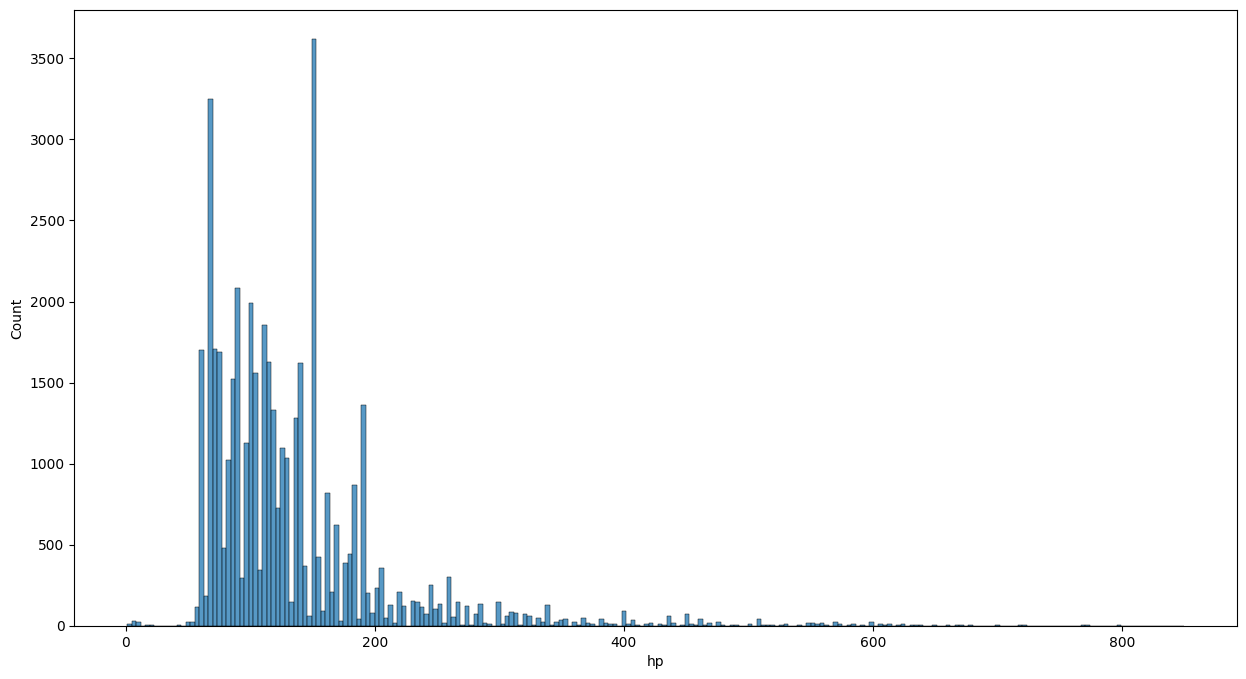

In [23]:
plt.figure(figsize=(15,8))
sns.histplot(cars_data['hp']);

### DISTRIBUIÇÃO DE VEÍCULOS POR ANO

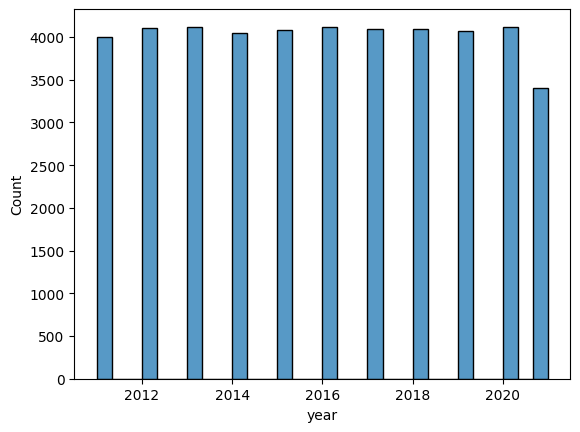

In [24]:
sns.histplot(cars_data['year']);

## VERIFICANDO VARIÁVEIS CATEGÓRICAS

### QUANTIDADE DE VEÍCULOS POR MARCA

In [25]:
cars_data.make.sort_values().unique()

array(['9ff', 'Abarth', 'Aixam', 'Alfa', 'Alpina', 'Alpine', 'Aston',
       'Audi', 'BMW', 'Baic', 'Bentley', 'Brilliance', 'Cadillac',
       'Caravans-Wohnm', 'Chevrolet', 'Chrysler', 'Citroen', 'Corvette',
       'Cupra', 'DAF', 'DFSK', 'DS', 'Dacia', 'Daihatsu', 'Dodge',
       'Estrima', 'FISKER', 'Ferrari', 'Fiat', 'Ford', 'Honda', 'Hyundai',
       'Infiniti', 'Isuzu', 'Iveco', 'Jaguar', 'Jeep', 'Kia', 'Lada',
       'Lamborghini', 'Lancia', 'Land', 'Lexus', 'Ligier', 'MINI',
       'Maserati', 'Maybach', 'Mazda', 'McLaren', 'Mercedes-Benz',
       'Microcar', 'Mitsubishi', 'Morgan', 'Nissan', 'Opel', 'Others',
       'Peugeot', 'Piaggio', 'Polestar', 'Porsche', 'RAM', 'Renault',
       'Rolls-Royce', 'SEAT', 'Skoda', 'SsangYong', 'Subaru', 'Suzuki',
       'Tazzari', 'Tesla', 'Toyota', 'Trailer-Anhänger', 'Trucks-Lkw',
       'Volkswagen', 'Volvo', 'Zhidou', 'smart'], dtype=object)

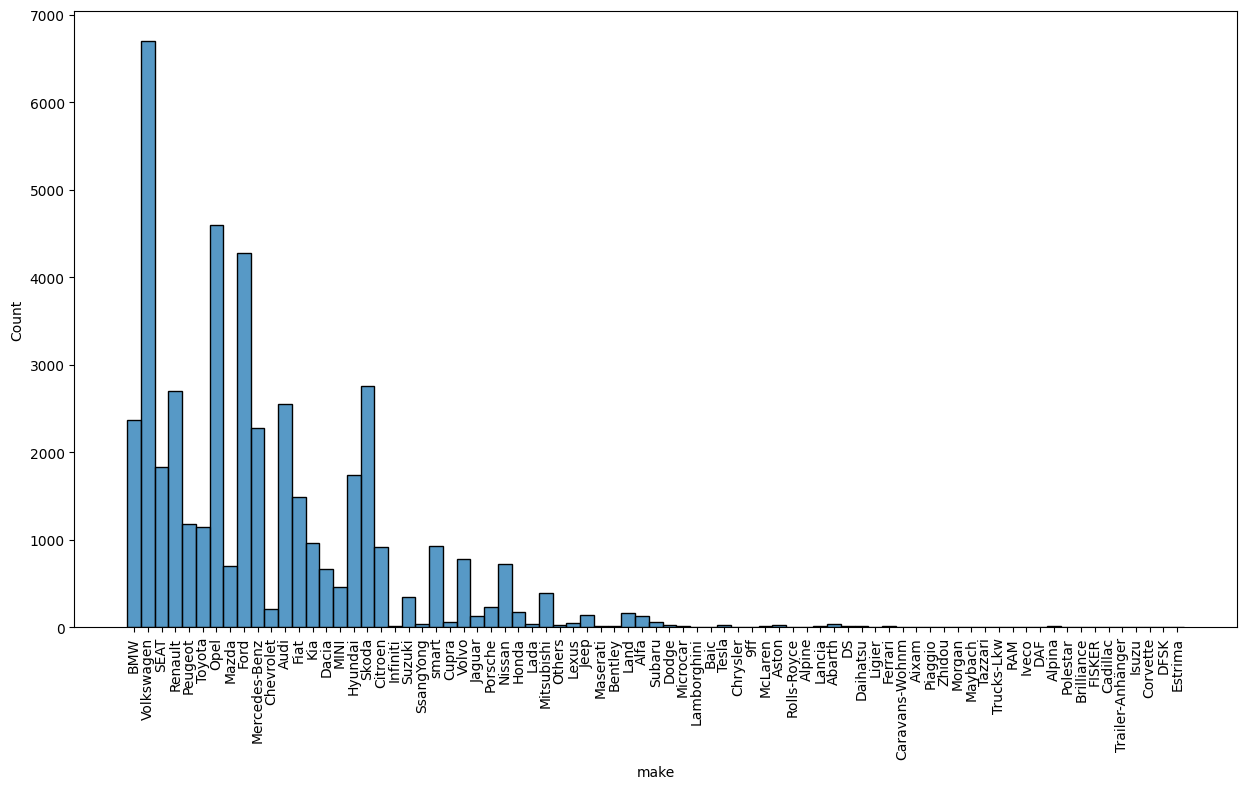

In [26]:
plt.figure(figsize=(15,8))
sns.histplot(cars_data['make'], bins='auto')
plt.xticks(rotation=90);

### QUANTIDADE DE VEÍCULOS POR TIPO DE COMBUSTÍVEL

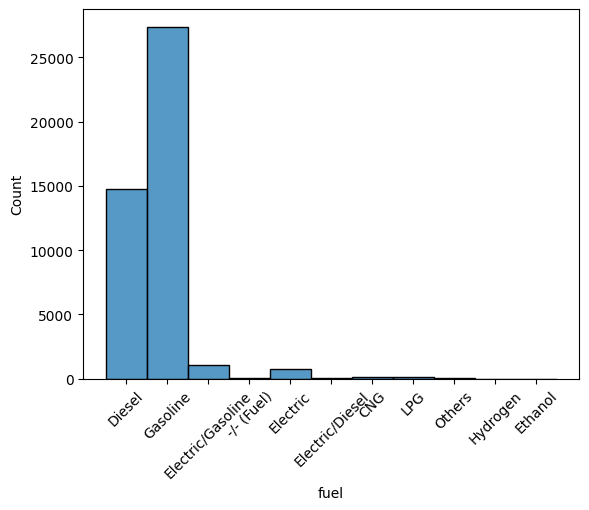

In [27]:
sns.histplot(cars_data['fuel']);
plt.xticks(rotation=45);

### QUANTIDADE DE VEÍCULOS POR TIPO DE CÂMBIO

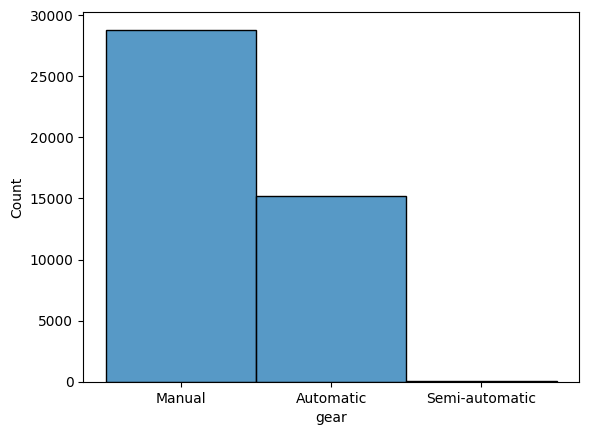

In [28]:
sns.histplot(cars_data['gear']);

### QUANTIDADE DE VEÍCULOS POR ESTADO DE USO

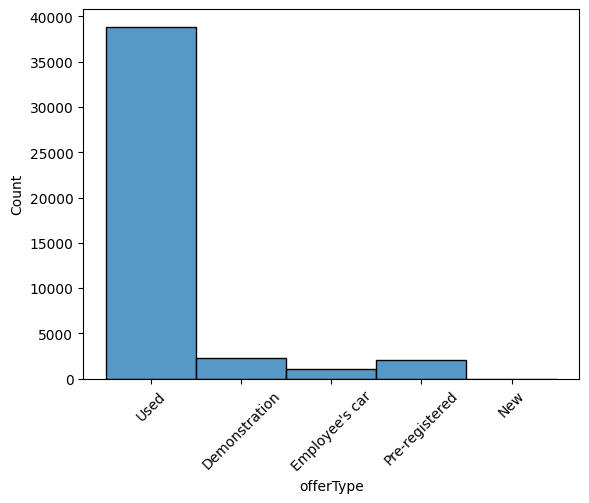

In [29]:
sns.histplot(cars_data['offerType']);
plt.xticks(rotation=45);

## ANÁLISE BIVARIADA

### QUANTIDADE DE MODELOS ÚNICOS POR MARCA

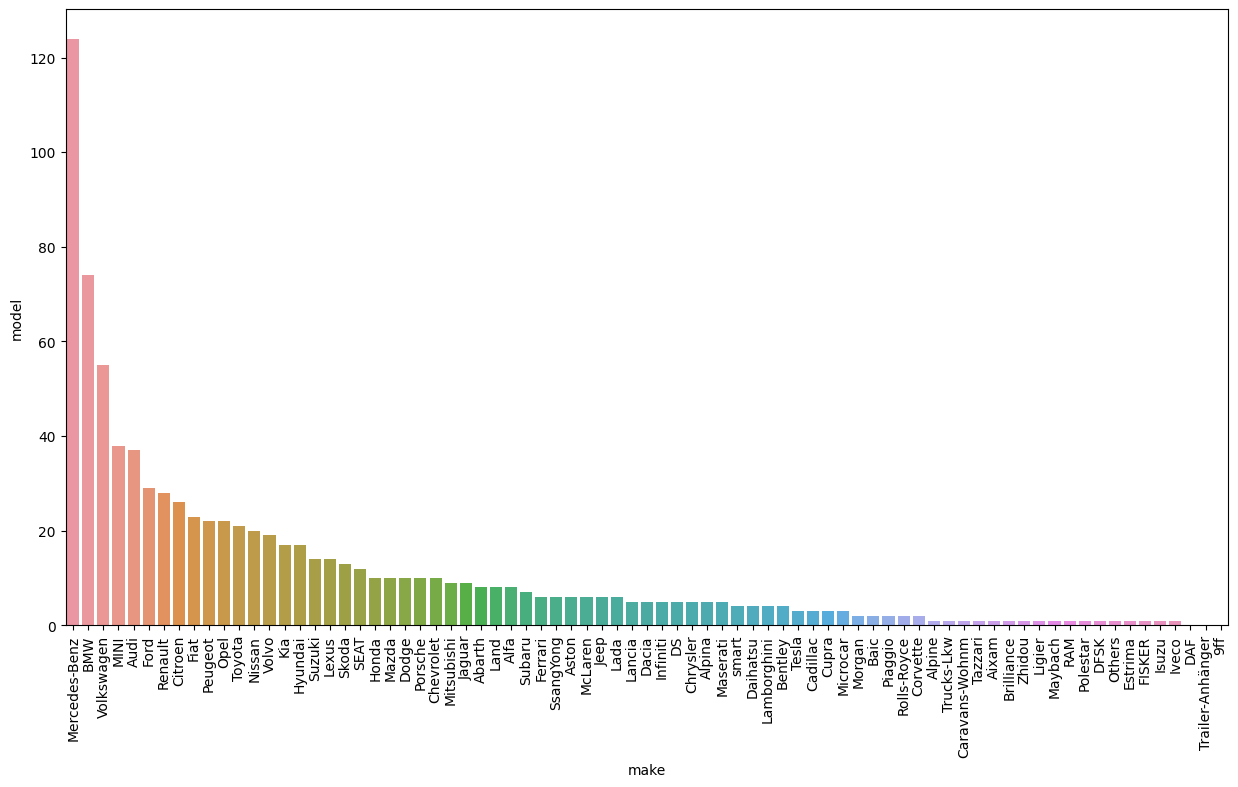

In [30]:
df_aux = cars_data[['make', 'model']].groupby('make').nunique().sort_values(by='model', ascending=False).reset_index()

plt.figure(figsize=(15,8))
sns.barplot(x=df_aux['make'], y=df_aux['model'])
plt.xticks(rotation=90);

### VALOR MÉDIO DA POTÊNCIA DO MOTOR POR MARCA

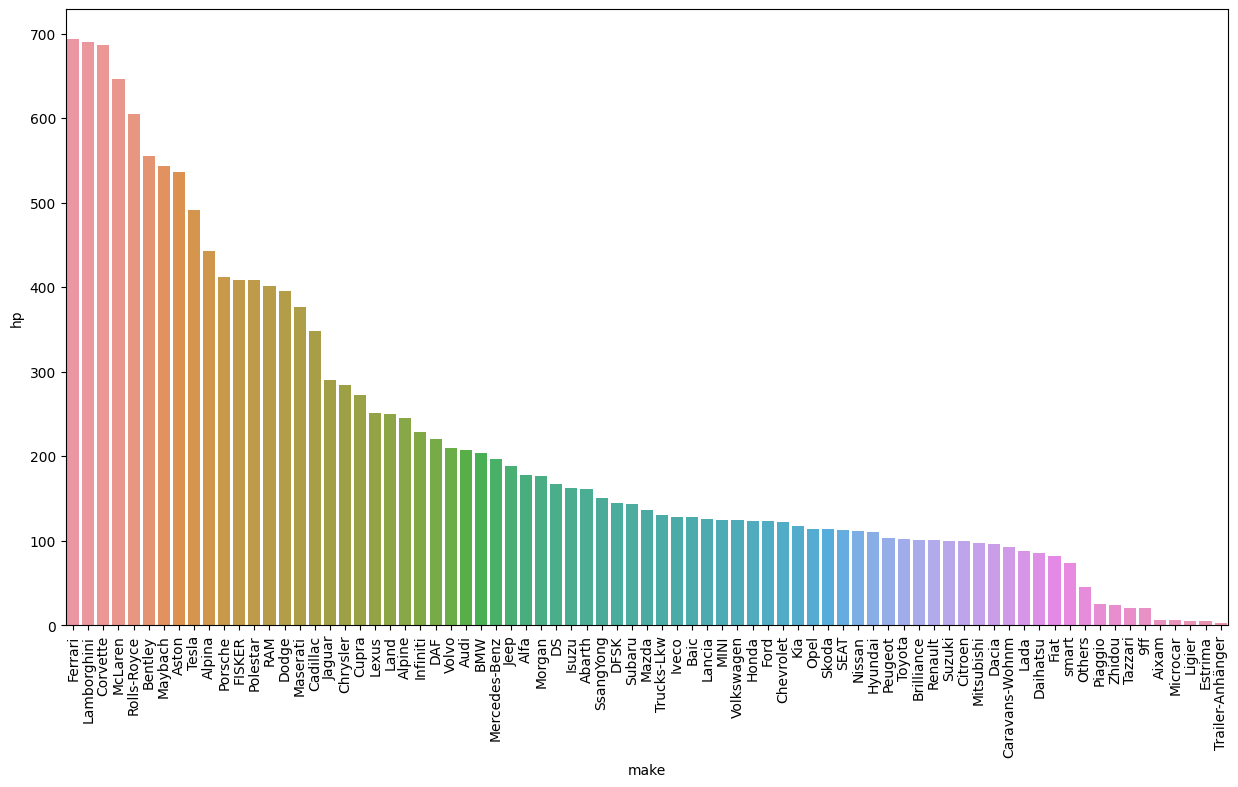

In [31]:
df_aux = cars_data[['make', 'hp']].groupby('make').mean().sort_values(by='hp', ascending=False).reset_index()

plt.figure(figsize=(15,8))
sns.barplot(x=df_aux['make'], y=df_aux['hp'])
plt.xticks(rotation=90);

### VALOR MÉDIO POR MARCA DE VEÍCULO

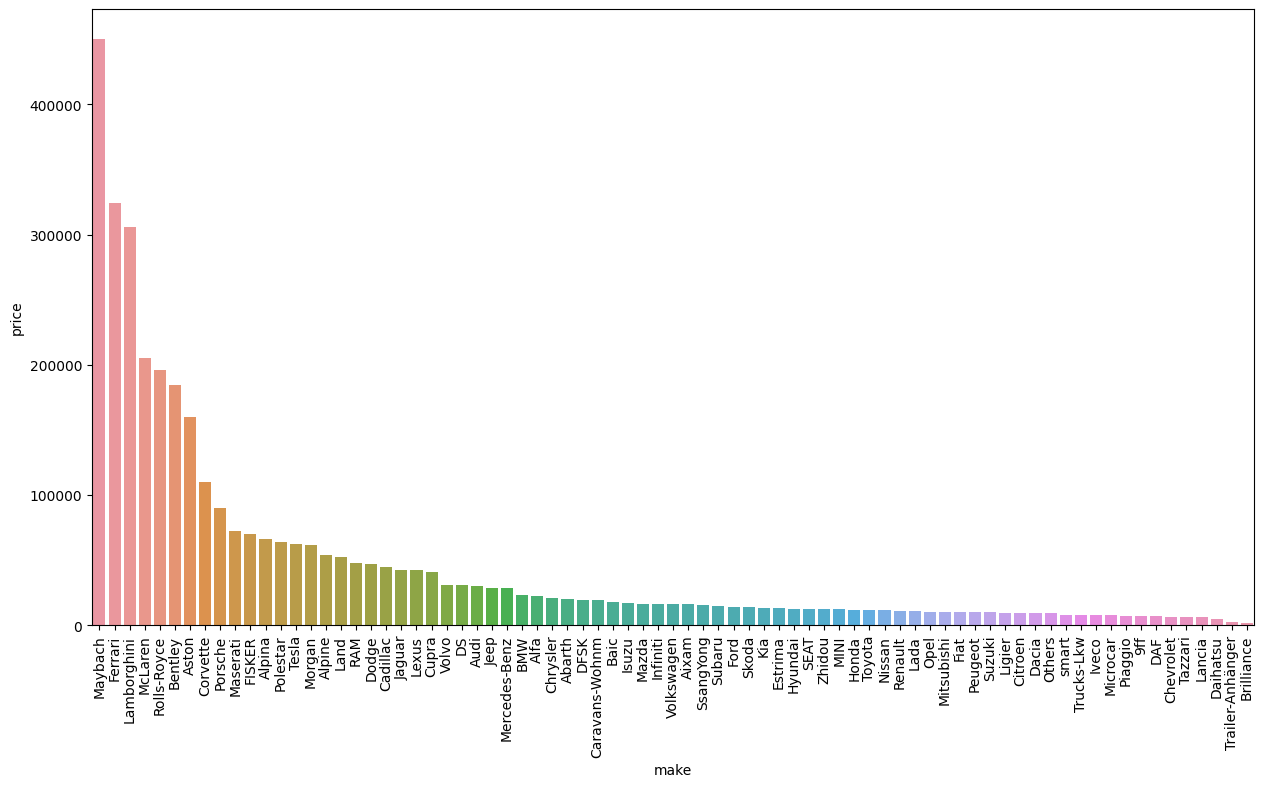

In [72]:
df_aux = cars_data[['make', 'price']].groupby('make').mean().sort_values(by='price', ascending=False).reset_index()

plt.figure(figsize=(15,8))
sns.barplot(x=df_aux['make'], y=df_aux['price'])
plt.xticks(rotation=90);

### RELAÇÃO ENTRE O VALOR DO VEÍCULO E A POTÊNCIA DO MOTOR

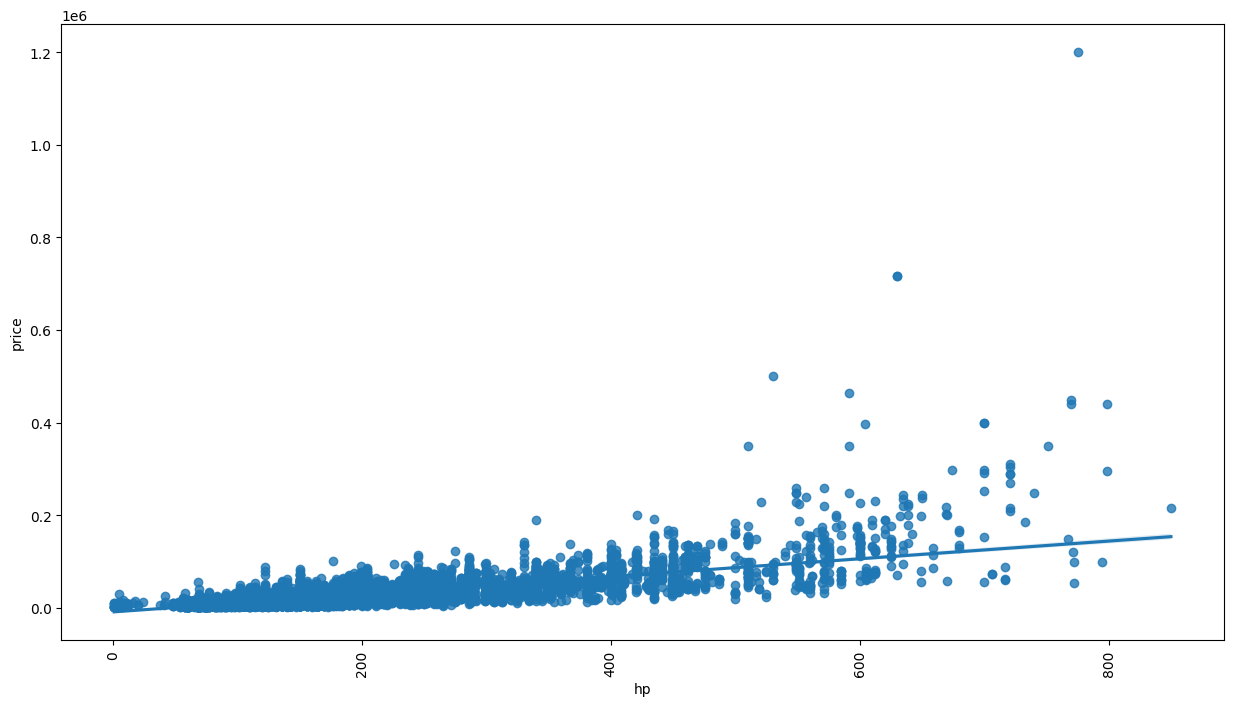

In [98]:
df_aux = cars_data[['price', 'hp']]

plt.figure(figsize=(15,8))
sns.regplot(x=df_aux['hp'], y=df_aux['price'])
plt.xticks(rotation=90);

### RELAÇÃO ENTRE O VALOR DO VEÍCULO E A QUILOMETRAGEM

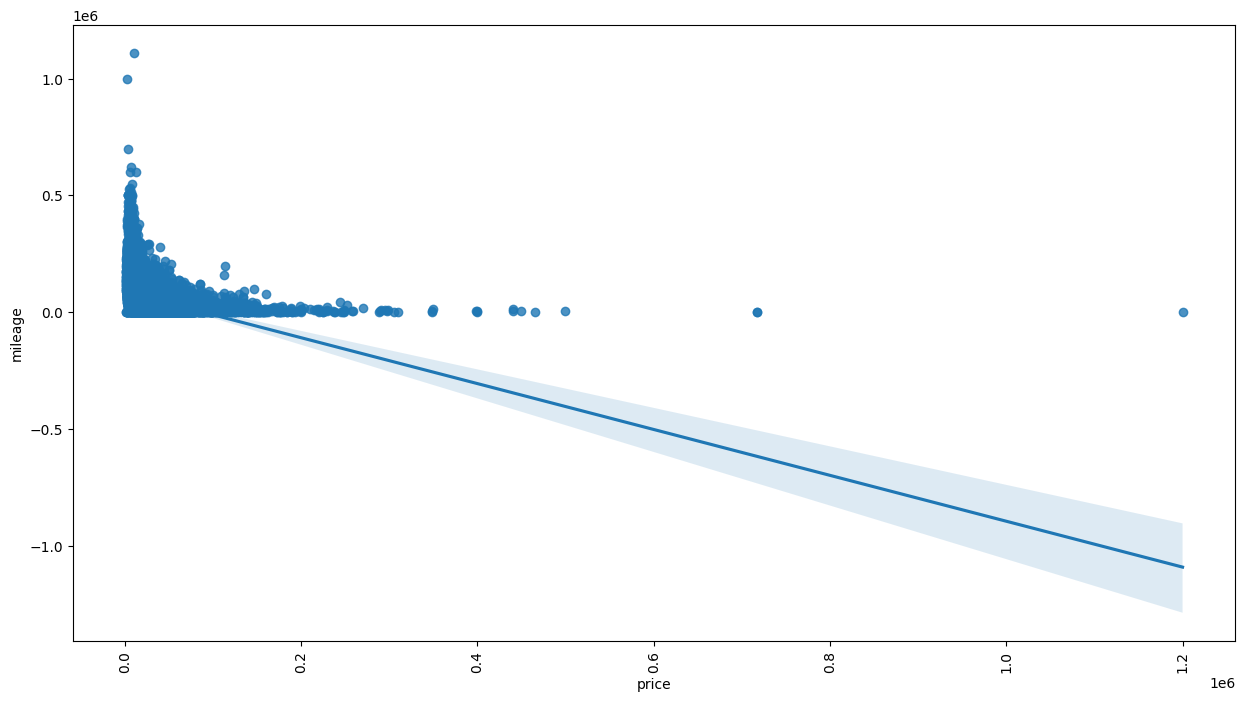

In [96]:
df_aux = cars_data[['price', 'mileage']]

plt.figure(figsize=(15,8))
sns.regplot(x=df_aux['price'], y=df_aux['mileage'])
plt.xticks(rotation=90);

### RELAÇÃO ENTRE PREÇO E MARCA

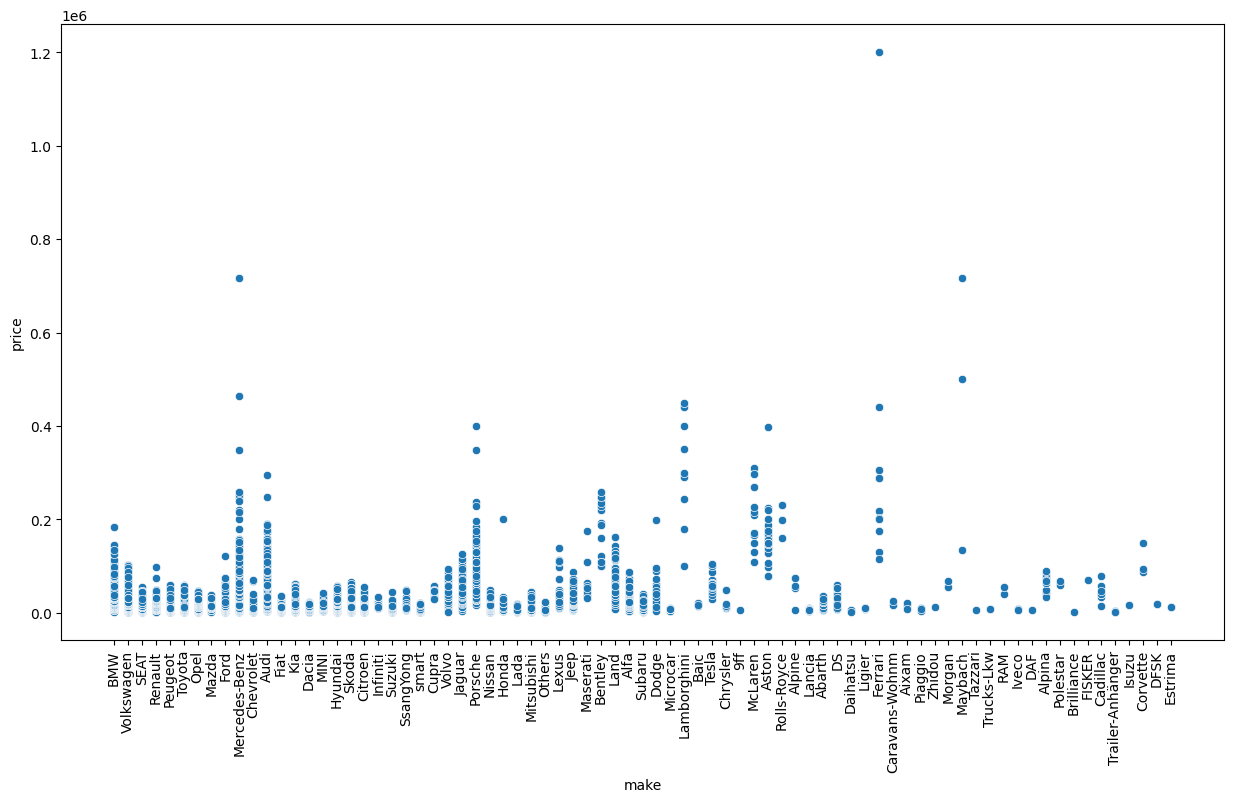

In [86]:
df_aux = cars_data[['price', 'make']]

plt.figure(figsize=(15,8))
sns.scatterplot(data=df_aux, x='make', y='price')
plt.xticks(rotation=90);

### DISTRIBUIÇÃO DE VEÍCULOS QUE CUSTAM MAIS DE 19.490 EUROS POR MARCA

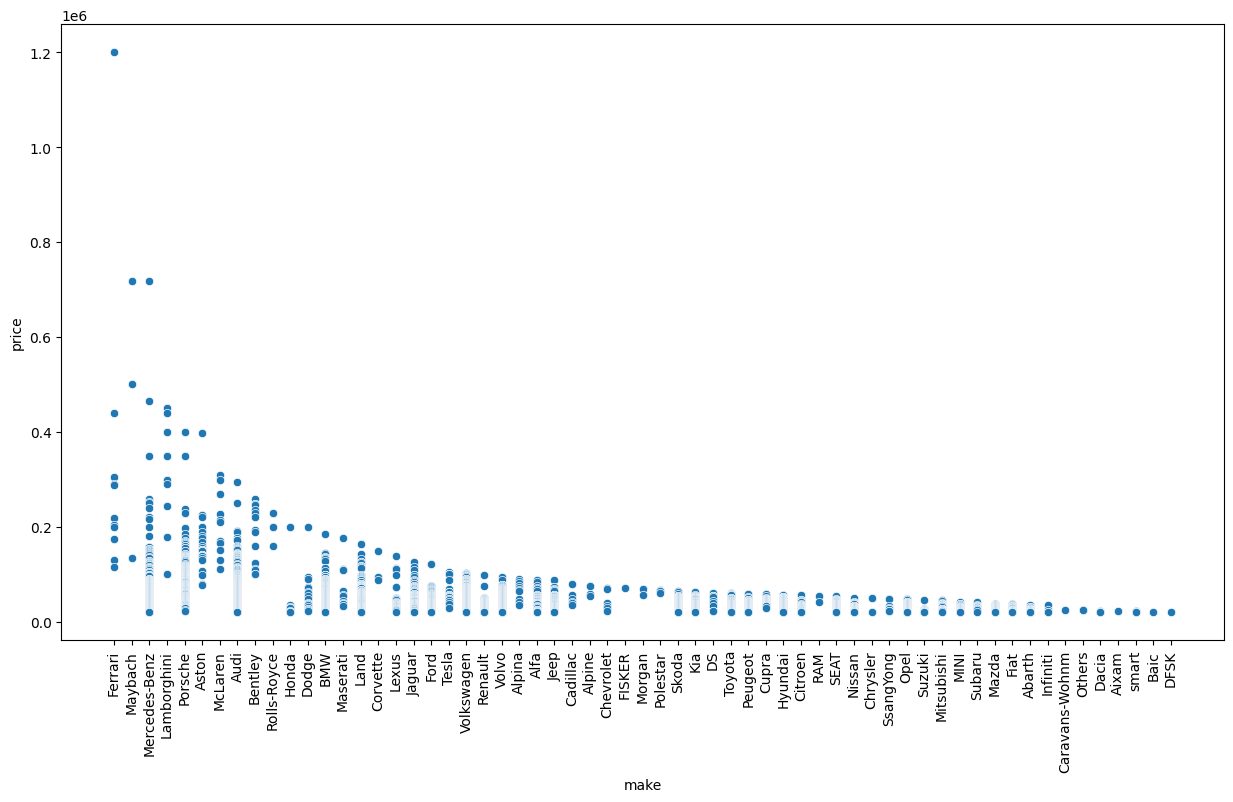

In [87]:
df_aux = cars_data.loc[(cars_data['price'] > 19490), :].sort_values(by='price', ascending=False).reset_index()

plt.figure(figsize=(15,8))
sns.scatterplot(data=df_aux, x='make', y='price')
plt.xticks(rotation=90);

### DISTRIBUIÇÃO DE VEÍCULOS QUE CUSTAM MENOS DE 19.490 EUROS POR MARCA

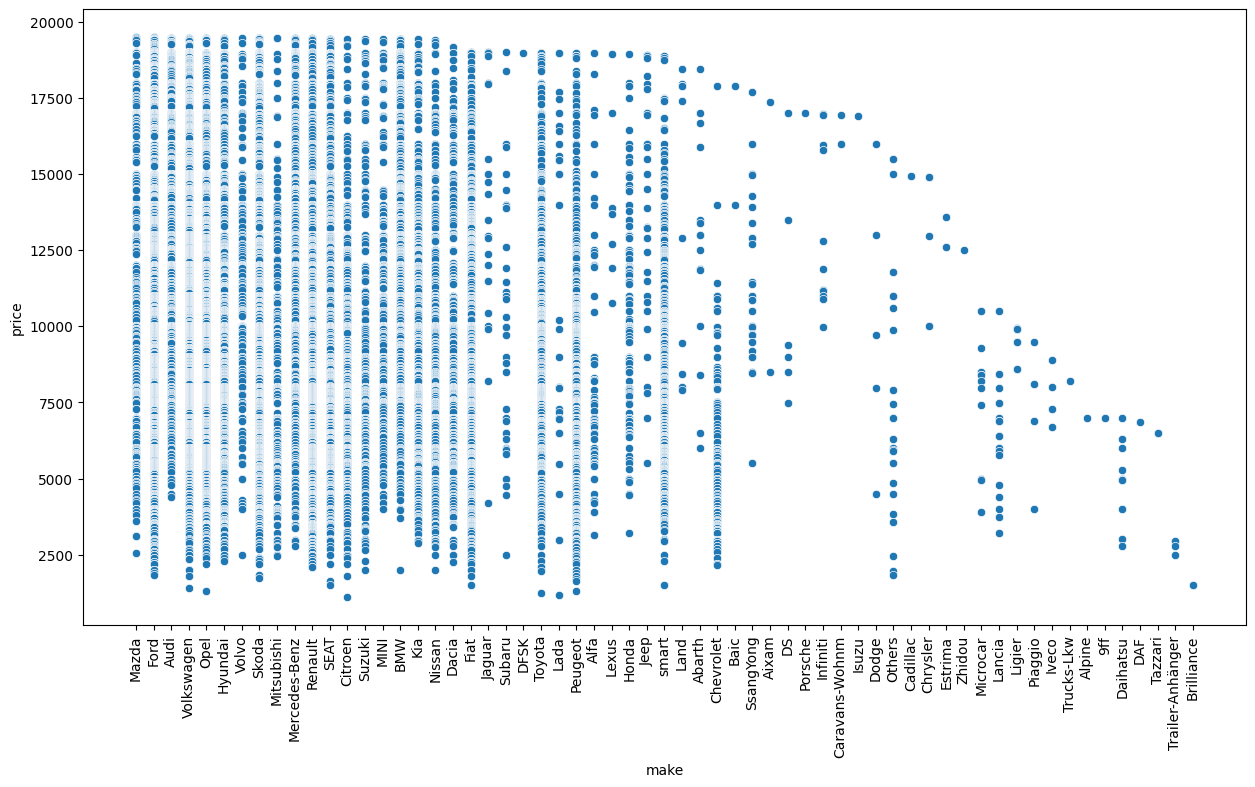

In [92]:
df_price_max = cars_data.loc[(cars_data['price'] < 19490), :].sort_values(by='price', ascending=False).reset_index()

plt.figure(figsize=(15,8))
sns.scatterplot(data=df_price_max, x='make', y='price')
plt.xticks(rotation=90);

### CORRELAÇÃO ENTRE VARIÁVEIS

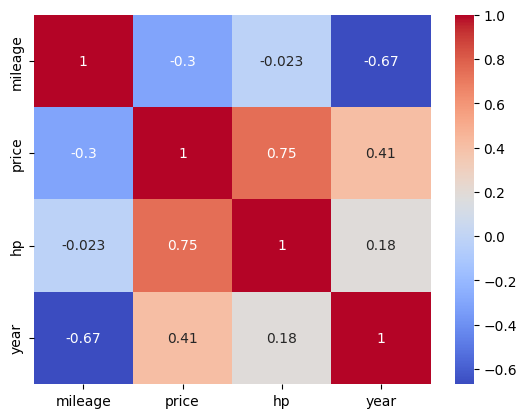

In [36]:
# determinando a matrix de correlação
corr_matrix = cars_data.corr(method='pearson')

# criando o heatmap com seaborn
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm');

## DETECÇÃO DE OUTLIERS

### IQR

In [37]:
# selecionando a coluna price, removendo valores nulos e criando um array
preco = np.array(cars_data['price'].dropna())

# calculando os quartis e o intervalo interquartil
primeiro_quartil = np.percentile(preco, 25)
terceiro_quartil = np.percentile(preco, 75)
iqr = terceiro_quartil - primeiro_quartil

# definir o limite para identificar outliers (1,5 vezes o IQR)
limite_inferior = primeiro_quartil - 1.5 * iqr
limite_superior = terceiro_quartil + 1.5 * iqr

# identificar os outliers
outliers = [x for x in preco if x < limite_inferior or x > limite_superior]

print('Outliers identificados: ', len(outliers))

Outliers identificados:  3082


In [ ]:
# criando o dataset sem outliers
cars_data_outliers_iqr = cars_data.drop(cars_data[cars_data['price'].isin(outliers)].index)

### DESVIO-PADRÃO

In [38]:
# selecionando a preco price, removendo valores nulos e criando um array
preco = np.array(cars_data['price'].dropna())

# definindo o número de desvios padrão para considerar como outlier
n_desvios_padrao = 3

# calculando a média e o desvio padrão da preco de dados
media = np.mean(preco)
desvio_padrao = np.std(preco)

# definindo o limite para identificar outliers
limite_inferior = media - n_desvios_padrao * desvio_padrao
limite_superior = media + n_desvios_padrao * desvio_padrao

# identificando os outliers
outliers = [x for x in preco if x < limite_inferior or x > limite_superior]

print('Número de outliers: ', len(outliers))

Número de outliers:  571


In [ ]:
# criando o dataset sem outliers
cars_data_outliers_std = cars_data.drop(cars_data[cars_data['price'].isin(outliers)].index)

### Z-SCORE

In [39]:
# selecionando a coluna price, removendo valores nulos e criando um array
preco = np.array(cars_data['price'].dropna())

# criando uma variável com o cálculo de z-score
z_scores = stats.zscore(preco)

# identificando valores com pontuação superior ao valor absoluto 3
outliers = [preco[i] for i, z in enumerate(z_scores) if abs(z) > 3]

print('Número de outliers: ', len(outliers))

Número de outliers:  571


In [40]:
# selecionando a coluna price, removendo valores nulos e criando um array
preco = np.array(cars_data['price'].dropna())

# calculando a média e o desvio padrão da coluna preço
mean = np.mean(preco)
std = np.std(preco)

# criando uma variável com o cálculo de z-score
z_scores = (preco - mean) / std

# identificando valores com pontuação superior ao valor absoluto 3
outliers = [preco[i] for i, z in enumerate(z_scores) if abs(z) > 3]

print('Número de outliers: ', len(outliers))

Número de outliers:  571


In [93]:
# criando o dataset sem outliers
cars_data_outliers_zscore = cars_data.drop(cars_data[cars_data['price'].isin(outliers)].index)

### ISOLATION FOREST

In [41]:
# selecionando a coluna price, removendo valores nulos e criando um array
preco = np.array(cars_data['price'].dropna())
preco = preco.reshape(-1, 1)

# criando uma instância do Isolation Forest
iforest = IsolationForest(n_estimators=100, contamination=0.05)

# ajustando o modelo aos dados
iforest.fit(preco)

# identificando os outliers
outliers = preco[iforest.predict(preco) == -1]

print('Número de outliers:', len(outliers))

Número de outliers: 2208


In [ ]:
# criando o dataset sem outliers
mask = iforest.predict(preco) != -1
cars_data_outliers_isolation_forest = cars_data[mask]

### DBSCAN

In [42]:
# selecionando a coluna price, removendo valores nulos e criando um array
preco = np.array(cars_data['price'].dropna())
preco = preco.reshape(-1, 1)

# criando uma instância do DBSCAN
dbscan = DBSCAN(eps=1000, min_samples=10)

# ajustando o modelo aos dados
dbscan.fit(preco)

# identificando os outliers
outliers = preco[dbscan.labels_ == -1]

print('Número de outliers:', len(outliers))

Número de outliers: 158


In [ ]:
# criando o dataset sem outliers
mask = dbscan.labels_ != -1
cars_data_outliers_dbscan = cars_data[mask]

In [43]:
# import matplotlib.pyplot as plt

# # plotando os dados
# plt.scatter(range(len(preco)), preco)

# # plotando os outliers em vermelho
# plt.scatter(np.where(dbscan.labels_ == -1), outliers, c='red', label='outliers')

# # configurando o gráfico
# plt.title('Gráfico de Dispersão de Preços')
# plt.xlabel('Índice')
# plt.ylabel('Preço')
# plt.legend()

# # exibindo o gráfico
# plt.show()

### LOCAL OUTLIER FACTOR

In [44]:
cars_aux = cars_data.copy()

# selecionar as colunas de interesse
X = np.array(cars_aux['price'].dropna())
X= X.reshape(-1, 1)

# instanciar o modelo LOF
model = LocalOutlierFactor(n_neighbors=5, contamination=0.05)

# ajustar o modelo aos dados e prever os rótulos de cada ponto
y_pred = model.fit_predict(X)

# adicionar os rótulos de outlier como uma nova coluna no DataFrame
cars_aux['outlier'] = y_pred

# filtrar os pontos rotulados como outliers
outliers = cars_aux[cars_aux['outlier'] == -1]

# imprimir a lista de outliers identificados
print('Número de outliers:', len(outliers))

Número de outliers: 1966


In [ ]:
# criando o dataset sem outliers
mask = y_pred != -1
cars_data_outliers_lof = cars_aux[mask]

# FEATURE ENGINEERING

## TRANSFORMANDO A COLUNA DE COMBUSTÍVEL

In [15]:
cars_data['fuel'].unique()

array(['Diesel', 'Gasoline', 'Electric/Gasoline', '-/- (Fuel)',
       'Electric', 'Electric/Diesel', 'CNG', 'LPG', 'Others', 'Hydrogen',
       'Ethanol'], dtype=object)

In [16]:
cars_fuel =({
    'Diesel':'Diesel',
    'Gasoline':'Gasoline',
    'Electric':'Electric',
    'Electric/Gasoline':'Hybrid',
    'Electric/Diesel':'Hybrid',
    'CNG':'Others',
    'LPG':'Others',
    'Others':'Others',
    'Hydrogen':'Others',
    'Ethanol':'Others',
    '-/- (Fuel)':'Others'})

In [17]:
cars_data['fuel'] = cars_data['fuel'].map(cars_fuel)

# PREPROCESSING

In [48]:
# separando o target das features de previsão
X = cars_data.copy()
X.drop(['price'], axis=1, inplace=True)

y = cars_data['price']

In [49]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [50]:
# pré-processamento dos dados numéricos
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                                        ('scaler', RobustScaler())
                                       ])


# pré-processamento dos dados categóricos
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('catboost', ce.cat_boost.CatBoostEncoder())
                                       ])

# pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)
    
])

# MODELO COM OUTLIERS

In [51]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=3, n_estimators=200, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# treino do modelo
pipeline = pipeline.fit(X_train, y_train)

# predição
prediction = pipeline.predict(X_test)

# métricas de avaliação
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)

# visualizando os valores das métricas
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 2235.0484910160662
Mean Absolute Percentage Error: 0.13767827393380433
Root Mean Squared Error: 5437.4290163805435


In [52]:
# definindo os parâmetros a serem testados
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

# criando a função de procura dos parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# resultado com os melhores parâmetros e resultado RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

Best parameters found:  {'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 300}
Best RMSE score found:  9659.03790986069


In [53]:
# definição do modelo
model = XGBRegressor(eta=0.01, max_depth=5, n_estimators=300, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# fit do modelo
pipeline = pipeline.fit(X_train, y_train)

# utilizando cross-validation para verificar a performance do modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)


# visualizando o valor, a média e devio-padrão do RMSE
print("RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE scores:", rmse_scores.std())

RMSE Scores: [ 5107.76952407 10143.30571471 11264.68250371  5360.12764453
  8675.15669909]
Mean RMSE: 8110.208417222064
Standard deviation of RMSE scores: 2489.214394464165


In [54]:
print(pipeline.predict(pd.DataFrame([[43654, 'BMW', '325i', 'Gasoline', 'Automatic', 'Used', 224, 2016]], columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

[23222.154]


In [55]:
# BMW 135 - Price €27990
# https://www.autoscout24.com/offers/bmw-135-m135ias-utilitaire-gasoline-orange-e49445d9-5abc-4471-b61b-e7ca7eae95eb?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=5&position=5&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("BMW 135 -",pipeline.predict(pd.DataFrame([[76690, 'BMW', '135', 'Gasoline', 'Automatic', 'Used', 326, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Subaru Impreza - Price €25999
# https://www.autoscout24.com/offers/subaru-impreza-2-5-wrx-sti-sport-plus-gasoline-1cf591b3-1d5b-401a-a2b9-39aafa6a5e88?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=3&position=3&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Subaru Impreza -",pipeline.predict(pd.DataFrame([[100, 'Subaru', 'Impreza', 'Gasoline', 'Manual', 'Used', 300, 2011]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Audi A3 - Price €4500
# https://www.autoscout24.com/offers/audi-a3-1-8-ambiente-gasoline-black-c78fbe15-c65e-40f1-9794-f2a6312fee9d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Audi A3 -",pipeline.predict(pd.DataFrame([[217000, 'Audi', 'A3', 'Gasoline', 'Manual', 'Used', 125, 1999]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Mercedes-Benz E 220 - Price €16750
# https://www.autoscout24.com/offers/mercedes-benz-e-220-bluetec-be-edition-led-navi-tempom-sitzh-diesel-black-af6c6eb9-d3e5-4983-b584-210eada0a13d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=1&position=1&search_id=fsed1hs44y&source_otp=nfm&source=listpage_search-results&order_bucket=unknown&topspot-algorithm=nfm-default&topspot-dealer-id=41743645
print("Mercedes-Benz E 220 -",pipeline.predict(pd.DataFrame([[184000, 'Mercedes-Benz', 'E 220', 'Diesel', 'Automatic', 'Used', 170, 2015]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Jaguar F-Type - Price €198990
# https://www.autoscout24.com/offers/jaguar-f-type-f-type-project-7-limited-gasoline-black-abe2b89d-d36e-46a2-9527-66a2c91d5c95?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=1k5smh8i8ol&source_otp=t30&source=listpage_search-results&order_bucket=2
print("Jaguar F-Type -",pipeline.predict(pd.DataFrame([[4117, 'Jaguar', 'F-Type', 'Gasoline', 'Automatic', 'Used', 583, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

BMW 135 - [28503.611]
Subaru Impreza - [30621.117]
Audi A3 - [7700.662]
Mercedes-Benz E 220 - [12692.144]
Jaguar F-Type - [161437.92]


# MODELO SEM OUTLIERS UTILIZANDO O MÉTODO IQR

In [58]:
# separando o target das features de previsão
X = cars_data_outliers_iqr.copy()
X.drop(['price'], axis=1, inplace=True)

y = cars_data_outliers_iqr['price']

In [59]:
# divisão dos dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [60]:
# pré-processamento dos dados numéricos
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                                        ('scaler', RobustScaler())
                                       ])


# pré-processamento dos dados categóricos
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('catboost', ce.cat_boost.CatBoostEncoder())
                                       ])

# pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)
    
])

In [61]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=3, n_estimators=200, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# treino do modelo
pipeline = pipeline.fit(X_train, y_train)

# predição
prediction = pipeline.predict(X_test)

# métricas de avaliação
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)

# visualizando os valores das métricas
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 1482.4958203243564
Mean Absolute Percentage Error: 0.12513133754425987
Root Mean Squared Error: 2177.715673161505


In [62]:
# definindo os parâmetros a serem testados
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

# criando a função de procura dos parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# resultado com os melhores parâmetros e resultado RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300}
Best RMSE score found:  2039.6831229484924


In [63]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=7, n_estimators=300, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# fit do modelo
pipeline = pipeline.fit(X_train, y_train)

# utilizando cross-validation para verificar a performance do modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# visualizando o valor, a média e devio-padrão do RMSE
print("RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE scores:", rmse_scores.std())

RMSE Scores: [1897.41627954 2434.67176006 3218.41368329 2547.13994834 2440.47329953]
Mean RMSE: 2507.622994150742
Standard deviation of RMSE scores: 421.65582932709736


In [64]:
print(pipeline.predict(pd.DataFrame([[43654, 'BMW', '325i', 'Gasoline', 'Automatic', 'Used', 224, 2016]], columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

[25872.102]


In [65]:
# BMW 135 - Price €27990
# https://www.autoscout24.com/offers/bmw-135-m135ias-utilitaire-gasoline-orange-e49445d9-5abc-4471-b61b-e7ca7eae95eb?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=5&position=5&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("BMW 135 -",pipeline.predict(pd.DataFrame([[76690, 'BMW', '135', 'Gasoline', 'Automatic', 'Used', 326, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Subaru Impreza - Price €25999
# https://www.autoscout24.com/offers/subaru-impreza-2-5-wrx-sti-sport-plus-gasoline-1cf591b3-1d5b-401a-a2b9-39aafa6a5e88?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=3&position=3&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Subaru Impreza -",pipeline.predict(pd.DataFrame([[100, 'Subaru', 'Impreza', 'Gasoline', 'Manual', 'Used', 300, 2011]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Audi A3 - Price €4500
# https://www.autoscout24.com/offers/audi-a3-1-8-ambiente-gasoline-black-c78fbe15-c65e-40f1-9794-f2a6312fee9d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Audi A3 -",pipeline.predict(pd.DataFrame([[217000, 'Audi', 'A3', 'Gasoline', 'Manual', 'Used', 125, 1999]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Mercedes-Benz E 220 - Price €16750
# https://www.autoscout24.com/offers/mercedes-benz-e-220-bluetec-be-edition-led-navi-tempom-sitzh-diesel-black-af6c6eb9-d3e5-4983-b584-210eada0a13d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=1&position=1&search_id=fsed1hs44y&source_otp=nfm&source=listpage_search-results&order_bucket=unknown&topspot-algorithm=nfm-default&topspot-dealer-id=41743645
print("Mercedes-Benz E 220 -",pipeline.predict(pd.DataFrame([[184000, 'Mercedes-Benz', 'E 220', 'Diesel', 'Automatic', 'Used', 170, 2015]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Jaguar F-Type - Price €198990
# https://www.autoscout24.com/offers/jaguar-f-type-f-type-project-7-limited-gasoline-black-abe2b89d-d36e-46a2-9527-66a2c91d5c95?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=1k5smh8i8ol&source_otp=t30&source=listpage_search-results&order_bucket=2
print("Jaguar F-Type -",pipeline.predict(pd.DataFrame([[4117, 'Jaguar', 'F-Type', 'Gasoline', 'Automatic', 'Used', 583, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

BMW 135 - [30418.494]
Subaru Impreza - [18433.518]
Audi A3 - [5913.786]
Mercedes-Benz E 220 - [15362.106]
Jaguar F-Type - [33837.957]


# MODELO SEM OUTLIERS UTILIZANDO O MÉTODO DESVIO-PADRÃO

In [68]:
# separando o target das features de previsão
X = cars_data_outliers_std.copy()
X.drop(['price'], axis=1, inplace=True)

y = cars_data_outliers_std['price']

In [69]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [70]:
# pré-processamento dos dados numéricos
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                                        ('scaler', RobustScaler())
                                       ])


# pré-processamento dos dados categóricos
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('catboost', ce.cat_boost.CatBoostEncoder())
                                       ])

# pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)
    
])

In [71]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=3, n_estimators=200, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# treino do modelo
pipeline = pipeline.fit(X_train, y_train)

# predição
prediction = pipeline.predict(X_test)

# métricas de avaliação
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)

# visualizando os valores das métricas
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 1773.8376531144813
Mean Absolute Percentage Error: 0.12623409442785816
Root Mean Squared Error: 2873.065463247578


In [72]:
# definindo os parâmetros a serem testados
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

# criando a função de procura dos parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# resultado com os melhores parâmetros e resultado RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}
Best RMSE score found:  2885.953878493144


In [73]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=5, n_estimators=300, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# fit do modelo
pipeline = pipeline.fit(X_train, y_train)

# utilizando cross-validation para verificar a performance do modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# visualizando o valor, a média e devio-padrão do RMSE
print("RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE scores:", rmse_scores.std())

RMSE Scores: [3757.34914536 2871.72020972 3552.19854146 3141.27087158 3435.9642258 ]
Mean RMSE: 3351.7005987839766
Standard deviation of RMSE scores: 311.93344519730084


In [74]:
print(pipeline.predict(pd.DataFrame([[43654, 'BMW', '325i', 'Gasoline', 'Automatic', 'Used', 224, 2016]], columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

[24169.736]


In [75]:
# BMW 135 - Price €27990
# https://www.autoscout24.com/offers/bmw-135-m135ias-utilitaire-gasoline-orange-e49445d9-5abc-4471-b61b-e7ca7eae95eb?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=5&position=5&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("BMW 135 -",pipeline.predict(pd.DataFrame([[76690, 'BMW', '135', 'Gasoline', 'Automatic', 'Used', 326, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Subaru Impreza - Price €25999
# https://www.autoscout24.com/offers/subaru-impreza-2-5-wrx-sti-sport-plus-gasoline-1cf591b3-1d5b-401a-a2b9-39aafa6a5e88?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=3&position=3&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Subaru Impreza -",pipeline.predict(pd.DataFrame([[100, 'Subaru', 'Impreza', 'Gasoline', 'Manual', 'Used', 300, 2011]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Audi A3 - Price €4500
# https://www.autoscout24.com/offers/audi-a3-1-8-ambiente-gasoline-black-c78fbe15-c65e-40f1-9794-f2a6312fee9d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Audi A3 -",pipeline.predict(pd.DataFrame([[217000, 'Audi', 'A3', 'Gasoline', 'Manual', 'Used', 125, 1999]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Mercedes-Benz E 220 - Price €16750
# https://www.autoscout24.com/offers/mercedes-benz-e-220-bluetec-be-edition-led-navi-tempom-sitzh-diesel-black-af6c6eb9-d3e5-4983-b584-210eada0a13d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=1&position=1&search_id=fsed1hs44y&source_otp=nfm&source=listpage_search-results&order_bucket=unknown&topspot-algorithm=nfm-default&topspot-dealer-id=41743645
print("Mercedes-Benz E 220 -",pipeline.predict(pd.DataFrame([[184000, 'Mercedes-Benz', 'E 220', 'Diesel', 'Automatic', 'Used', 170, 2015]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Jaguar F-Type - Price €198990
# https://www.autoscout24.com/offers/jaguar-f-type-f-type-project-7-limited-gasoline-black-abe2b89d-d36e-46a2-9527-66a2c91d5c95?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=1k5smh8i8ol&source_otp=t30&source=listpage_search-results&order_bucket=2
print("Jaguar F-Type -",pipeline.predict(pd.DataFrame([[4117, 'Jaguar', 'F-Type', 'Gasoline', 'Automatic', 'Used', 583, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

BMW 135 - [29944.037]
Subaru Impreza - [27381.281]
Audi A3 - [6261.934]
Mercedes-Benz E 220 - [15342.159]
Jaguar F-Type - [69370.31]


# MODELO SEM OUTLIERS UTILIZANDO O MÉTODO Z-SCORE

In [78]:
# separando o target das features de previsão
X = cars_data_outliers_zscore.copy()
X.drop(['price'], axis=1, inplace=True)

y = cars_data_outliers_zscore['price']

In [79]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [80]:
# pré-processamento dos dados numéricos
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                                        ('scaler', RobustScaler())
                                       ])


# pré-processamento dos dados categóricos
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('catboost', ce.cat_boost.CatBoostEncoder())
                                       ])

# pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)
    
])

In [81]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=3, n_estimators=200, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# treino do modelo
pipeline = pipeline.fit(X_train, y_train)

# predição
prediction = pipeline.predict(X_test)

# métricas de avaliação
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)

# visualizando os valores das métricas
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 1773.8376531144813
Mean Absolute Percentage Error: 0.12623409442785816
Root Mean Squared Error: 2873.065463247578


In [82]:
# definindo os parâmetros a serem testados
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

# criando a função de procura dos parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# resultado com os melhores parâmetros e resultado RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}
Best RMSE score found:  2885.953878493144


In [83]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=5, n_estimators=300, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# fit do modelo
pipeline = pipeline.fit(X_train, y_train)

# utilizando cross-validation para verificar a performance do modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# visualizando o valor, a média e devio-padrão do RMSE
print("RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE scores:", rmse_scores.std())

RMSE Scores: [3757.34914536 2871.72020972 3552.19854146 3141.27087158 3435.9642258 ]
Mean RMSE: 3351.7005987839766
Standard deviation of RMSE scores: 311.93344519730084


In [84]:
print(pipeline.predict(pd.DataFrame([[43654, 'BMW', '325i', 'Gasoline', 'Automatic', 'Used', 224, 2016]], columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

[24169.736]


In [85]:
# BMW 135 - Price €27990
# https://www.autoscout24.com/offers/bmw-135-m135ias-utilitaire-gasoline-orange-e49445d9-5abc-4471-b61b-e7ca7eae95eb?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=5&position=5&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("BMW 135 -",pipeline.predict(pd.DataFrame([[76690, 'BMW', '135', 'Gasoline', 'Automatic', 'Used', 326, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Subaru Impreza - Price €25999
# https://www.autoscout24.com/offers/subaru-impreza-2-5-wrx-sti-sport-plus-gasoline-1cf591b3-1d5b-401a-a2b9-39aafa6a5e88?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=3&position=3&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Subaru Impreza -",pipeline.predict(pd.DataFrame([[100, 'Subaru', 'Impreza', 'Gasoline', 'Manual', 'Used', 300, 2011]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Audi A3 - Price €4500
# https://www.autoscout24.com/offers/audi-a3-1-8-ambiente-gasoline-black-c78fbe15-c65e-40f1-9794-f2a6312fee9d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Audi A3 -",pipeline.predict(pd.DataFrame([[217000, 'Audi', 'A3', 'Gasoline', 'Manual', 'Used', 125, 1999]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Mercedes-Benz E 220 - Price €16750
# https://www.autoscout24.com/offers/mercedes-benz-e-220-bluetec-be-edition-led-navi-tempom-sitzh-diesel-black-af6c6eb9-d3e5-4983-b584-210eada0a13d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=1&position=1&search_id=fsed1hs44y&source_otp=nfm&source=listpage_search-results&order_bucket=unknown&topspot-algorithm=nfm-default&topspot-dealer-id=41743645
print("Mercedes-Benz E 220 -",pipeline.predict(pd.DataFrame([[184000, 'Mercedes-Benz', 'E 220', 'Diesel', 'Automatic', 'Used', 170, 2015]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Jaguar F-Type - Price €198990
# https://www.autoscout24.com/offers/jaguar-f-type-f-type-project-7-limited-gasoline-black-abe2b89d-d36e-46a2-9527-66a2c91d5c95?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=1k5smh8i8ol&source_otp=t30&source=listpage_search-results&order_bucket=2
print("Jaguar F-Type -",pipeline.predict(pd.DataFrame([[4117, 'Jaguar', 'F-Type', 'Gasoline', 'Automatic', 'Used', 583, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

BMW 135 - [29944.037]
Subaru Impreza - [27381.281]
Audi A3 - [6261.934]
Mercedes-Benz E 220 - [15342.159]
Jaguar F-Type - [69370.31]


# MODELO SEM OUTLIERS UTILIZANDO O MÉTODO ISOLATION FOREST

In [88]:
# separando o target das features de previsão
X = cars_data_outliers_isolation_forest.copy()
X.drop(['price'], axis=1, inplace=True)

y = cars_data_outliers_isolation_forest['price']

In [89]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [90]:
# pré-processamento dos dados numéricos
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                                        ('scaler', RobustScaler())
                                       ])


# pré-processamento dos dados categóricos
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('catboost', ce.cat_boost.CatBoostEncoder())
                                       ])

# pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)
    
])

In [91]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=3, n_estimators=200, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# treino do modelo
pipeline = pipeline.fit(X_train, y_train)

# predição
prediction = pipeline.predict(X_test)

# métricas de avaliação
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)

# visualizando os valores das métricas
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 1579.2169567391172
Mean Absolute Percentage Error: 0.12361428132576291
Root Mean Squared Error: 2353.1628105407426


In [92]:
# definindo os parâmetros a serem testados
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

# criando a função de procura dos parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# resultado com os melhores parâmetros e resultado RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 300}
Best RMSE score found:  2251.6696214406265


In [93]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=7, n_estimators=300, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# fit do modelo
pipeline = pipeline.fit(X_train, y_train)

# utilizando cross-validation para verificar a performance do modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# visualizando o valor, a média e devio-padrão do RMSE
print("RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE scores:", rmse_scores.std())

RMSE Scores: [2126.31025405 2557.7202664  3339.76786801 2543.04546812 2649.46867664]
Mean RMSE: 2643.2625066430573
Standard deviation of RMSE scores: 392.3668681459437


In [94]:
print(pipeline.predict(pd.DataFrame([[43654, 'BMW', '325i', 'Gasoline', 'Automatic', 'Used', 224, 2016]], columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

[25549.832]


In [95]:
# BMW 135 - Price €27990
# https://www.autoscout24.com/offers/bmw-135-m135ias-utilitaire-gasoline-orange-e49445d9-5abc-4471-b61b-e7ca7eae95eb?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=5&position=5&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("BMW 135 -",pipeline.predict(pd.DataFrame([[76690, 'BMW', '135', 'Gasoline', 'Automatic', 'Used', 326, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Subaru Impreza - Price €25999
# https://www.autoscout24.com/offers/subaru-impreza-2-5-wrx-sti-sport-plus-gasoline-1cf591b3-1d5b-401a-a2b9-39aafa6a5e88?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=3&position=3&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Subaru Impreza -",pipeline.predict(pd.DataFrame([[100, 'Subaru', 'Impreza', 'Gasoline', 'Manual', 'Used', 300, 2011]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Audi A3 - Price €4500
# https://www.autoscout24.com/offers/audi-a3-1-8-ambiente-gasoline-black-c78fbe15-c65e-40f1-9794-f2a6312fee9d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Audi A3 -",pipeline.predict(pd.DataFrame([[217000, 'Audi', 'A3', 'Gasoline', 'Manual', 'Used', 125, 1999]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Mercedes-Benz E 220 - Price €16750
# https://www.autoscout24.com/offers/mercedes-benz-e-220-bluetec-be-edition-led-navi-tempom-sitzh-diesel-black-af6c6eb9-d3e5-4983-b584-210eada0a13d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=1&position=1&search_id=fsed1hs44y&source_otp=nfm&source=listpage_search-results&order_bucket=unknown&topspot-algorithm=nfm-default&topspot-dealer-id=41743645
print("Mercedes-Benz E 220 -",pipeline.predict(pd.DataFrame([[184000, 'Mercedes-Benz', 'E 220', 'Diesel', 'Automatic', 'Used', 170, 2015]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Jaguar F-Type - Price €198990
# https://www.autoscout24.com/offers/jaguar-f-type-f-type-project-7-limited-gasoline-black-abe2b89d-d36e-46a2-9527-66a2c91d5c95?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=1k5smh8i8ol&source_otp=t30&source=listpage_search-results&order_bucket=2
print("Jaguar F-Type -",pipeline.predict(pd.DataFrame([[4117, 'Jaguar', 'F-Type', 'Gasoline', 'Automatic', 'Used', 583, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

BMW 135 - [31516.283]
Subaru Impreza - [22157.656]
Audi A3 - [5409.309]
Mercedes-Benz E 220 - [16423.943]
Jaguar F-Type - [41129.29]


# MODELO SEM OUTLIERS UTILIZANDO O MÉTODO DBSCAN

In [46]:
# separando o target das features de previsão
X = cars_data_outliers_dbscan.copy()
X.drop(['price'], axis=1, inplace=True)

y = cars_data_outliers_dbscan['price']

In [47]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [48]:
# pré-processamento dos dados numéricos
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                                        ('scaler', RobustScaler())
                                       ])


# pré-processamento dos dados categóricos
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('catboost', ce.cat_boost.CatBoostEncoder())
                                       ])

# pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)
    
])

In [49]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=3, n_estimators=200, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# treino do modelo
pipeline = pipeline.fit(X_train, y_train)

# predição
prediction = pipeline.predict(X_test)

# métricas de avaliação
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)

# visualizando os valores das métricas
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 2033.0690941372745
Mean Absolute Percentage Error: 0.13468444375735597
Root Mean Squared Error: 3679.1149801856873


In [50]:
# definindo os parâmetros a serem testados
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

# criando a função de procura dos parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# resultado com os melhores parâmetros e resultado RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

Best parameters found:  {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__n_estimators': 300}
Best RMSE score found:  3758.3727467103176


In [51]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=5, n_estimators=300, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# fit do modelo
pipeline = pipeline.fit(X_train, y_train)

# utilizando cross-validation para verificar a performance do modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# visualizando o valor, a média e devio-padrão do RMSE
print("RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE scores:", rmse_scores.std())

RMSE Scores: [3840.34700161 3348.13399379 4132.33326242 3597.18895456 4449.05636489]
Mean RMSE: 3873.4119154538516
Standard deviation of RMSE scores: 387.74117751866874


In [52]:
print(pipeline.predict(pd.DataFrame([[43654, 'BMW', '325i', 'Gasoline', 'Automatic', 'Used', 224, 2016]], columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

[27440.438]


In [53]:
# BMW 135 - Price €27990
# https://www.autoscout24.com/offers/bmw-135-m135ias-utilitaire-gasoline-orange-e49445d9-5abc-4471-b61b-e7ca7eae95eb?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=5&position=5&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("BMW 135 -",pipeline.predict(pd.DataFrame([[76690, 'BMW', '135', 'Gasoline', 'Automatic', 'Used', 326, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Subaru Impreza - Price €25999
# https://www.autoscout24.com/offers/subaru-impreza-2-5-wrx-sti-sport-plus-gasoline-1cf591b3-1d5b-401a-a2b9-39aafa6a5e88?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=3&position=3&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Subaru Impreza -",pipeline.predict(pd.DataFrame([[100, 'Subaru', 'Impreza', 'Gasoline', 'Manual', 'Used', 300, 2011]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Audi A3 - Price €4500
# https://www.autoscout24.com/offers/audi-a3-1-8-ambiente-gasoline-black-c78fbe15-c65e-40f1-9794-f2a6312fee9d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Audi A3 -",pipeline.predict(pd.DataFrame([[217000, 'Audi', 'A3', 'Gasoline', 'Manual', 'Used', 125, 1999]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Mercedes-Benz E 220 - Price €16750
# https://www.autoscout24.com/offers/mercedes-benz-e-220-bluetec-be-edition-led-navi-tempom-sitzh-diesel-black-af6c6eb9-d3e5-4983-b584-210eada0a13d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=1&position=1&search_id=fsed1hs44y&source_otp=nfm&source=listpage_search-results&order_bucket=unknown&topspot-algorithm=nfm-default&topspot-dealer-id=41743645
print("Mercedes-Benz E 220 -",pipeline.predict(pd.DataFrame([[184000, 'Mercedes-Benz', 'E 220', 'Diesel', 'Automatic', 'Used', 170, 2015]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Jaguar F-Type - Price €198990
# https://www.autoscout24.com/offers/jaguar-f-type-f-type-project-7-limited-gasoline-black-abe2b89d-d36e-46a2-9527-66a2c91d5c95?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=1k5smh8i8ol&source_otp=t30&source=listpage_search-results&order_bucket=2
print("Jaguar F-Type -",pipeline.predict(pd.DataFrame([[4117, 'Jaguar', 'F-Type', 'Gasoline', 'Automatic', 'Used', 583, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

BMW 135 - [30282.51]
Subaru Impreza - [32369.787]
Audi A3 - [6568.6577]
Mercedes-Benz E 220 - [13692.887]
Jaguar F-Type - [109246.99]


# MODELO SEM OUTLIERS UTILIZANDO O LOCAL OUTLIER FACTOR

In [56]:
# criando o dataset sem outliers
cars_data_outliers_lof = cars_data.drop(cars_data[cars_data['price'].isin(outliers)].index)
cars_data_outliers_lof.shape

(46405, 9)

In [57]:
# separando o target das features de previsão
X = cars_data_outliers_lof.copy()
X.drop(['price'], axis=1, inplace=True)

y = cars_data_outliers_lof['price']

In [58]:
# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [59]:
# pré-processamento dos dados numéricos
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
numerical_transformer = Pipeline(steps=[('imputer', KNNImputer(n_neighbors=2)),
                                        ('scaler', RobustScaler())
                                       ])


# pré-processamento dos dados categóricos
cat_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant')),
                                        ('catboost', ce.cat_boost.CatBoostEncoder())
                                       ])

# pipeline de pré-processamento
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, num_cols),
                                                ('cat', categorical_transformer, cat_cols)
    
])

In [60]:
# definição do modelo
model = XGBRegressor(eta=0.1, max_depth=3, n_estimators=200, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# treino do modelo
pipeline = pipeline.fit(X_train, y_train)

# predição
prediction = pipeline.predict(X_test)

# métricas de avaliação
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)
rmse = mean_squared_error(y_test, prediction, squared=False)

# visualizando os valores das métricas
print('Mean Absolute Error:', mae)
print('Mean Absolute Percentage Error:', mape)
print('Root Mean Squared Error:', rmse)

Mean Absolute Error: 2334.8127666484897
Mean Absolute Percentage Error: 0.13726115146422735
Root Mean Squared Error: 8925.674249350492


In [71]:
# definindo os parâmetros a serem testados
param_grid = {
    'model__max_depth': [3, 5, 7],
    'model__n_estimators': [100, 200, 300],
    'model__learning_rate': [0.01, 0.1, 0.3],
}

# criando a função de procura dos parâmetros
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# ajustando o modelo aos dados
grid_search.fit(X_train, y_train)

# resultado com os melhores parâmetros e resultado RMSE
print("Best parameters found: ", grid_search.best_params_)
print("Best RMSE score found: ", np.sqrt(-grid_search.best_score_))

KeyboardInterrupt: 

In [68]:
# definição do modelo
model = XGBRegressor(eta=0.01, max_depth=5, n_estimators=300, random_state=0)

# pré-processamento e modelagem
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])

# fit do modelo
pipeline = pipeline.fit(X_train, y_train)

# utilizando cross-validation para verificar a performance do modelo
scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-scores)

# visualizando o valor, a média e devio-padrão do RMSE
print("RMSE Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation of RMSE scores:", rmse_scores.std())

RMSE Scores: [ 4977.05214718 10350.45959189 10759.29908313  5314.43988818
  8620.14727064]
Mean RMSE: 8004.279596205219
Standard deviation of RMSE scores: 2444.3129759038284


In [69]:
print(pipeline.predict(pd.DataFrame([[43654, 'BMW', '325i', 'Gasoline', 'Automatic', 'Used', 224, 2016]], columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

[22955.373]


In [70]:
# BMW 135 - Price €27990
# https://www.autoscout24.com/offers/bmw-135-m135ias-utilitaire-gasoline-orange-e49445d9-5abc-4471-b61b-e7ca7eae95eb?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=5&position=5&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("BMW 135 -",pipeline.predict(pd.DataFrame([[76690, 'BMW', '135', 'Gasoline', 'Automatic', 'Used', 326, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Subaru Impreza - Price €25999
# https://www.autoscout24.com/offers/subaru-impreza-2-5-wrx-sti-sport-plus-gasoline-1cf591b3-1d5b-401a-a2b9-39aafa6a5e88?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=3&position=3&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Subaru Impreza -",pipeline.predict(pd.DataFrame([[100, 'Subaru', 'Impreza', 'Gasoline', 'Manual', 'Used', 300, 2011]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Audi A3 - Price €4500
# https://www.autoscout24.com/offers/audi-a3-1-8-ambiente-gasoline-black-c78fbe15-c65e-40f1-9794-f2a6312fee9d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=vnwqc1tmoo&source_otp=t40&source=listpage_search-results&order_bucket=3
print("Audi A3 -",pipeline.predict(pd.DataFrame([[217000, 'Audi', 'A3', 'Gasoline', 'Manual', 'Used', 125, 1999]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Mercedes-Benz E 220 - Price €16750
# https://www.autoscout24.com/offers/mercedes-benz-e-220-bluetec-be-edition-led-navi-tempom-sitzh-diesel-black-af6c6eb9-d3e5-4983-b584-210eada0a13d?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=1&position=1&search_id=fsed1hs44y&source_otp=nfm&source=listpage_search-results&order_bucket=unknown&topspot-algorithm=nfm-default&topspot-dealer-id=41743645
print("Mercedes-Benz E 220 -",pipeline.predict(pd.DataFrame([[184000, 'Mercedes-Benz', 'E 220', 'Diesel', 'Automatic', 'Used', 170, 2015]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

# Jaguar F-Type - Price €198990
# https://www.autoscout24.com/offers/jaguar-f-type-f-type-project-7-limited-gasoline-black-abe2b89d-d36e-46a2-9527-66a2c91d5c95?sort=standard&desc=0&lastSeenGuidPresent=true&cldtidx=7&position=7&search_id=1k5smh8i8ol&source_otp=t30&source=listpage_search-results&order_bucket=2
print("Jaguar F-Type -",pipeline.predict(pd.DataFrame([[4117, 'Jaguar', 'F-Type', 'Gasoline', 'Automatic', 'Used', 583, 2016]], 
                           columns = ['mileage', 'make', 'model', 'fuel', 'gear', 'offerType', 'hp', 'year'])))

BMW 135 - [27745.283]
Subaru Impreza - [23969.154]
Audi A3 - [7576.8135]
Mercedes-Benz E 220 - [13106.637]
Jaguar F-Type - [215392.39]
